## Program Flow

1. モジュールインポート


In [18]:
# pandas(pd) とNumpy(np)のモジュール
import numpy as np
import pandas as pd
import sys,os,random
import warnings
warnings.filterwarnings('ignore')

# scikit learnの精度測定ツールの読み込み
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 

# scikit learnのテストデータの読み込み
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

# 変数定義

In [19]:
pram_traing_rate=0.4       #トレーニングデータとテストデータの比率

# 前処理済みファイルのロード

In [20]:
# 乱数のシード固定
np.random.seed(0)
random.seed(0)
# データフレームの表示件数の設定
pd.set_option('display.max_columns', 100)

# データロード
df = pd.read_csv('data/fx_preprocessing.csv', index_col=None)

y_loc_s=df.columns.get_loc('label_up')
y_loc_e=df.columns.get_loc('label_down')
df.tail(3)


# 前後のデータのカット
df3=df.loc[30:(len(df)-30)]
df2_num=df3.as_matrix()   #numpyへ変換

fx_len=len(df3)

#トレーニングデータと正解ラベルに分割


In [21]:
def label_ratio(df_tmp):

    # label数を揃える
    min_labels=[df_tmp[df_tmp['label_up']==1].shape[0],
         df_tmp[df_tmp['label_none']==1].shape[0],
         df_tmp[df_tmp['label_down']==1].shape[0]]

    min_sample=min(min_labels)


    # サンプル後再度結合
    df_tmp=pd.concat([
        df_tmp[df3['label_up']==1].sample(n=min_sample)
        ,df_tmp[df_tmp['label_down']==1].sample(n=min_sample)
        ,df_tmp[df_tmp['label_none']==1].sample(n=min_sample)
        ])

    print(df_tmp[df_tmp['label_up']==1].shape)
    print(df_tmp[df_tmp['label_none']==1].shape)
    print(df_tmp[df_tmp['label_down']==1].shape)
    
    return df_tmp


In [22]:
# データの分割
train, test = train_test_split(df3, train_size=pram_traing_rate,shuffle=False)

# labelの数を整える
train=label_ratio(train)

#トレーニングデータと正解ラベルに分割
trainX,testX=train.iloc[:,3:y_loc_s],test.iloc[:,3:y_loc_s]
trainY,testY=train.iloc[:,y_loc_s:y_loc_e+1],test.iloc[:,y_loc_s:y_loc_e+1]


#Numpy形式に変換
trainX,testX=trainX.as_matrix(),testX.as_matrix()
trainY,testY=trainY.as_matrix(),testY.as_matrix()

#データサンプル数の確認
print("トレーニングデータ",trainX.shape)
print("トレーニングデータ",trainY.shape)
print("　 　 テストデータ",testX.shape)
print("　 　 テストデータ",testY.shape)

(6, 77)
(6, 77)
(6, 77)
トレーニングデータ (18, 63)
トレーニングデータ (18, 3)
　 　 テストデータ (2926, 63)
　 　 テストデータ (2926, 3)


In [23]:


# データの分割
train, test = train_test_split(df3, train_size=pram_traing_rate,shuffle=True)

#トレーニングデータと正解ラベルに分割
trainX,testX=train.iloc[:,3:y_loc_s],test.iloc[:,3:y_loc_s]
trainY,testY=train.iloc[:,y_loc_s:y_loc_e+1],test.iloc[:,y_loc_s:y_loc_e+1]


#Numpy形式に変換
trainX,testX=trainX.as_matrix(),testX.as_matrix()
trainY,testY=trainY.as_matrix(),testY.as_matrix()

#データサンプル数の確認
print("トレーニングデータ",trainX.shape)
print("トレーニングデータ",trainY.shape)
print("　 　 テストデータ",testX.shape)
print("　 　 テストデータ",testY.shape)

トレーニングデータ (1950, 63)
トレーニングデータ (1950, 3)
　 　 テストデータ (2926, 63)
　 　 テストデータ (2926, 3)


In [24]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping,CSVLogger
from keras import callbacks
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam

print("データ数",len(trainY))
model= Sequential()
model.add(Dense(30,activation='relu',input_shape=(trainX.shape[1],)))      
model.add(Dropout(0.5))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(trainY.shape[1],activation='softmax'))
model.summary()
model.compile(loss="categorical_crossentropy", 
              optimizer="Adam", metrics=["accuracy"])

es_cb = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
tb_cb = callbacks.TensorBoard(log_dir='./logs/', histogram_freq=1)  

#cbks = [tb_cb,es_cb]
cbks = [tb_cb]

データ数 1950
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 30)                1920      
_________________________________________________________________
dropout_3 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                620       
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 63        
Total params: 2,603
Trainable params: 2,603
Non-trainable params: 0
_________________________________________________________________


In [25]:
# 学習処理
pram_epoch=200
history = model.fit(trainX,trainY,
                   batch_size=100,
                   epochs=pram_epoch,
                   verbose=0,
                   validation_data=(testX,testY),
                   #callbacks=cbks
                   )
        
#学習の評価
score=model.evaluate(testX,testY,verbose=1)

print('Test loass',score[0])
print('Test accuract',score[1]*100,"%")

2926/2926 [==============================] - 0s 21us/step
Test loass 1.0855956811735423
Test accuract 43.06220096304901 %


# モデルの保存

In [26]:
# モデルの保存
open('model/deep.json',"w").write(model.to_json())

# 学習済みの重みを保存
model.save_weights('model/deep_weight.h5')

# グラフによる精度の可視化


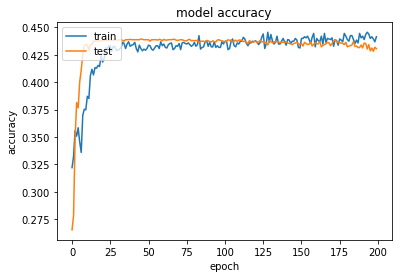

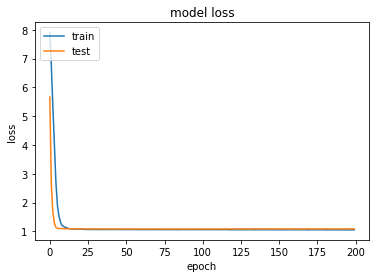

In [27]:
# グラフによる精度の可視化

import matplotlib.pyplot as plt
%matplotlib inline

#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# confution matrix

In [28]:
from sklearn import metrics
testYY=np.empty(0)
for i in testY:
    testYY=np.append(testYY,np.argmax(i))
predict_y=model.predict_classes(testX)

print("confusion matrix:")
print(metrics.confusion_matrix( testYY,predict_y))


print()
print("classification report:")
target_names = ['up','none','down']
print(metrics.classification_report(testYY,predict_y))

#metrics.classification_report
print("label_up",test[test['label_up']==1].shape[0])
print("label_none",test[test['label_none']==1].shape[0])
print("label_down",test[test['label_down']==1].shape[0])

confusion matrix:
[[1252   16   17]
 [ 856    4   13]
 [ 759    5    4]]

classification report:
             precision    recall  f1-score   support

        0.0       0.44      0.97      0.60      1285
        1.0       0.16      0.00      0.01       873
        2.0       0.12      0.01      0.01       768

avg / total       0.27      0.43      0.27      2926

label_up 1285
label_none 10
label_down 768


In [29]:
close_index=df.columns.get_loc('Close')
open_index=df.columns.get_loc('Open')
date_index=df.columns.get_loc('Date')
label_up_index=df.columns.get_loc('label_up')
label_down_index=df.columns.get_loc('label_down')


MONEY=1000000
resulst_out=""
LEN=len(df2_num)
GRAPH_X=[]
GRAPH_Y=[]

start=len(trainX)
end=len(df2_num)-1
print("start:",df2_num[start,0],"〜end:",df2_num[end,0])

standard=1000000/df2_num[start,1]  
DATE=""
result_out=""

df_sim = pd.DataFrame( columns=['Date', 'Open', 'Close', 'Up', 'money','result','predict','正誤','利益率'] )

start: 2008-04-03 〜end: 2019-07-22


In [30]:
for i in range(start,end): 
    # dfのカラムのインデックス()だけをPREに代入する
    PRE=df2_num[i,np.array([
                           2,
                           3,4,5,
                           6,7,8,
                           9,10,11,
                           12,13,14,
                           15,16,17,
                           18,19,20,
                           21,22,23,
                           24,25,26,
                           27,28,29,
                           30,31,32,

                           33,34,35,
                           36,37,38,
                           39,40,41,
                           42,43,44,
                           45,46,47,
                           48,49,50,
                           51,52,53,
                           54,55,56,
                           57,58,59,
                           60,61,62,
                           ])]

    #予測のコマンド
    PRE2 = model.predict_proba(np.resize(PRE,(1,trainX.shape[1])),verbose=0)
    PRE2=PRE2[0]

    DATE2=df2_num[i,date_index]
    
    if DATE != DATE2[:7]:       #月初の定点観測
        DATE=DATE2[:7]
        print()
        resulst_out=resulst_out+"\n"
        if DATE2[5:7]=="01":
            print("--------------------------------------------------------------------")
            resulst_out=resulst_out+"--------------------------------------------------------------------"+"\n"
        STRING=df2_num[i,0]+":資金"+"{:,}".format(int(MONEY))+"(基準"+"{:,}".format(int(standard*df2_num[i,1])).strip()+")"
        print(STRING.strip(),end="")
        result_out=result_out+STRING.strip()+"\n"



    PREDICT    ="None"
    profit_rate=0

    #  売り予測の場合
    if PRE2[2]>0.5:
        PREDICT="sell"
        #print("売:",end=" ")
        profit_rate=df2_num[i,open_index]/df2_num[i, close_index]
        MONEY=(profit_rate)*MONEY

    #  買い予測の場合
    if PRE2[0]>0.5:
        PREDICT="buy"
        #print("買",end=" ")
        profit_rate=df2_num[i,close_index]/df2_num[i,open_index]
        MONEY=(profit_rate)*MONEY


    if df2_num[i,label_up_index]==1:
        Y_result="buy"
    elif df2_num[i,label_down_index]==1:
        Y_result="sell"
    else:
        Y_result="None"

    seigo="×"    
    if Y_result==PREDICT:
        seigo="●"

    if profit_rate!=0:
        profit_rate=100*(profit_rate-1)

    s1 = pd.Series([df2_num[i,0],                           #日付
                    round(df2_num[i,open_index], 2),        #OPEN
                    round(df2_num[i,close_index],2),        #Close
                    round((df2_num[i,close_index]/df2_num[i,open_index]-1)*100,2),  #アップ率
                    round(MONEY),
                    Y_result,PREDICT,seigo,
                    round(profit_rate,2)],                     #予測
           index=df_sim.columns)
    df_sim=df_sim.append(s1,ignore_index=True)


2008-04-03:資金1,000,000(基準999,999)
2008-05-01:資金1,067,303(基準1,045,664)
2008-06-02:資金1,084,832(基準1,032,908)
2008-07-01:資金1,107,780(基準1,024,580)
2008-08-01:資金1,211,611(基準1,136,451)
2008-09-01:資金1,218,874(基準1,061,710)
2008-10-01:資金1,262,916(基準978,185)
2008-11-03:資金1,460,321(基準753,842)
2008-12-01:資金1,329,283(基準673,349)
--------------------------------------------------------------------
2009-01-01:資金1,364,231(基準728,095)
2009-02-02:資金1,301,623(基準671,070)
2009-03-02:資金1,361,327(基準703,941)
2009-04-01:資金1,439,824(基準800,923)
2009-05-01:資金1,338,112(基準896,884)
2009-06-01:資金1,305,301(基準922,082)
2009-07-01:資金1,295,280(基準949,886)
2009-08-03:資金1,262,211(基準935,485)
2009-09-01:資金1,250,358(基準895,878)
2009-10-01:資金1,286,680(基準885,241)
2009-11-02:資金1,204,162(基準863,563)
2009-12-01:資金1,191,270(基準904,008)
--------------------------------------------------------------------
2010-01-01:資金1,235,595(基準959,288)
2010-02-01:資金1,218,418(基準923,461)
2010-03-01:資金1,215,757(基準889,569)
2010-04-01:資金1,262,389(基準989,172)
2

In [31]:
# ファイルの保存
df_sim.to_csv('data/simulation.csv',index=False)

# 年毎の利益率の計算


In [32]:
print("●",df_sim[df_sim['正誤']=="●"].shape)
print("X",df_sim[df_sim['正誤']=="×"].shape)

for i in range(7,19):
    YEAR=str(i+2000)
    start=YEAR+"-01-01"
    end=YEAR+"-12-31"

    tmp=df_sim.query("Date >= @start and Date <= @end ")
    
    print("{:}年の利益率{:.2f}%".format(YEAR,tmp[['利益率']].sum()[0]))
df_sim[(
    df_sim['Date'].str.contains('-01-01$') |
    df_sim['Date'].str.contains('-04-01$') |
    df_sim['Date'].str.contains('-07-01$') |
    df_sim['Date'].str.contains('-10-01$') 
)]

● (989, 9)
X (1936, 9)
2007年の利益率0.00%
2008年の利益率37.68%
2009年の利益率-8.48%
2010年の利益率24.22%
2011年の利益率-4.07%
2012年の利益率0.46%
2013年の利益率13.39%
2014年の利益率-0.54%
2015年の利益率-3.68%
2016年の利益率2.78%
2017年の利益率-1.87%
2018年の利益率-5.29%


,Date,Open,Close,Up,money,result,predict,正誤,利益率
63,2008-07-01,13.50,13.45,-0.41,1107780,sell,None,×,0
129,2008-10-01,12.76,12.84,0.58,1262916,buy,None,×,0
195,2009-01-01,9.50,9.56,0.61,1364231,buy,None,×,0
259,2009-04-01,10.30,10.51,2.05,1439824,buy,None,×,0
324,2009-07-01,12.45,12.47,0.10,1295281,None,None,●,0
390,2009-10-01,11.84,11.62,-1.89,1286680,sell,None,×,0
456,2010-01-01,12.55,12.59,0.33,1235595,None,None,●,0
520,2010-04-01,12.81,12.98,1.33,1262390,buy,None,×,0
585,2010-07-01,11.50,11.32,-1.58,1429595,sell,None,×,0
651,2010-10-01,11.89,12.01,0.96,1467703,buy,buy,●,0.96


In [33]:
# 予測の数
print("予測buy: ",df_sim[df_sim['predict']=='buy'].shape[0])
print("予測None:",df_sim[df_sim['predict']=='None'].shape[0])
print("予測sell:",df_sim[df_sim['predict']=='sell'].shape[0])

# 購入予測した場合の勝率
df_buy=df_sim[df_sim['predict']=='buy']
print("購入予測数",df_buy.shape[0])

# 予測の内、実際の正解
print("予測の内,実際のbuy   :{:}({:.1f}%)".format(
    df_sim[df_sim['result']=='buy'].shape[0],
    df_buy[df_buy['result']=='buy'].shape[0]/df_buy.shape[0]*100))
print("予測の内,実際のNone  :{:}({:.1f}%)".format(
    df_sim[df_sim['result']=='None'].shape[0],
    df_buy[df_buy['result']=='None'].shape[0]/df_buy.shape[0]*100))
print("予測の内,実際のsell  :{:}({:.1f}%)".format(
    df_sim[df_sim['result']=='sell'].shape[0],
    df_buy[df_buy['result']=='sell'].shape[0]/df_buy.shape[0]*100))

予測buy:  461
予測None: 2138
予測sell: 326
購入予測数 461
予測の内,実際のbuy   :1204(41.2%)
予測の内,実際のNone  :918(31.2%)
予測の内,実際のsell  :803(27.5%)


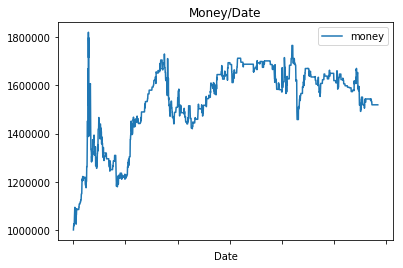

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

df_sim.plot(x='Date',y='money',title='Money/Date')